In [1]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt

I am currently reading the book SprawlBall by Kirk Goldsberry. In it, the author talks about how the 3 point line has changed the incentive structure in basketball. The points per shot (or the expected value of the shot) for three pointers and layups are significantly greater there than anywhere else inbetween. This got me thinking, if the NBA were to make a rule change mandating where the 3 point line should actually be, what is the "fairest" distance for them to move it to? Also, if they were to implement a 4 point line, where should that be located?

In [3]:
df=pd.read_csv(r'E:\Projects\Data Science Projects\NBA 3-point Line & 4-point Line\shot_logs.csv')
df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Create a pivot table that shows the make % and points per shot by distance. Another pivot table for sample sizes by shot

In [4]:
make_pct_dist=pd.pivot_table(df, index='SHOT_DIST', values=['FGM','PTS']).reset_index()
make_pct_dist_cnt=pd.pivot_table(df, index='SHOT_DIST', values=['FGM'], aggfunc='count').reset_index()

Plot showing fgm % and points per shot by distance

<AxesSubplot:>

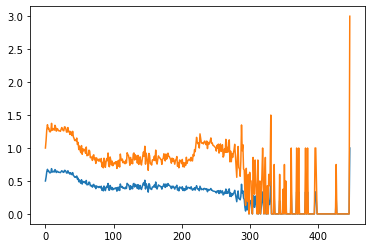

In [6]:
make_pct_dist.FGM.plot.line()
make_pct_dist.PTS.plot.line()

The data looks to get fairly sparse after ~ 27' I look into what range has an acceptable sample size

In [7]:
print(make_pct_dist_cnt.to_string())

     SHOT_DIST   FGM
0          0.0     4
1          0.1    59
2          0.2   100
3          0.3   164
4          0.4   206
5          0.5   289
6          0.6   337
7          0.7   352
8          0.8   412
9          0.9   451
10         1.0   441
11         1.1   508
12         1.2   556
13         1.3   609
14         1.4   608
15         1.5   629
16         1.6   621
17         1.7   709
18         1.8   686
19         1.9   748
20         2.0   830
21         2.1   801
22         2.2   849
23         2.3   857
24         2.4   833
25         2.5   877
26         2.6   835
27         2.7   851
28         2.8   876
29         2.9   906
30         3.0   930
31         3.1   926
32         3.2   900
33         3.3   879
34         3.4   909
35         3.5   893
36         3.6   854
37         3.7   865
38         3.8   908
39         3.9   844
40         4.0   793
41         4.1   882
42         4.2   807
43         4.3   792
44         4.4   802
45         4.5   803
46         4.

For shots inside of 27.3' we have > 100 samples. I will use this as the cut-off point. The FGM % attrition appears to be fairly linear outside of layups, so we can use a regression to expand this further if necessary

In [8]:
shot_samp=make_pct_dist[make_pct_dist.SHOT_DIST <=27.3]

Same plot without the messy data > 27.3

<AxesSubplot:xlabel='SHOT_DIST'>

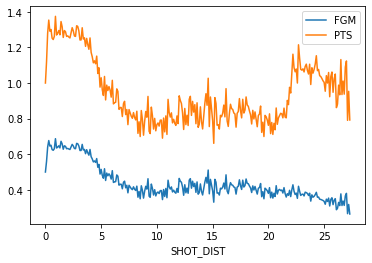

In [9]:
shot_samp.plot.line(x='SHOT_DIST')

Here we see the points per shot between the two point types

In [10]:
pd.pivot_table(df, index='PTS_TYPE', values='PTS')

,PTS
PTS_TYPE,
2,0.976713
3,1.054549


Plot 2 point expected value vs 3 point expected value on same chart. We see a huge spike in expected value right outside of the three point line. This is disproportional to any other two point area aside from at the rim.

In [11]:
two_pts=pd.pivot_table(df[(df.PTS_TYPE==2) & (df.SHOT_DIST <=22)], index='SHOT_DIST', values='PTS').reset_index()
three_pts=pd.pivot_table(df[(df.PTS_TYPE==3) & (df.SHOT_DIST >22) & (df.SHOT_DIST <=27.3)], index='SHOT_DIST', values='PTS').reset_index()

Here I plot the ev of two point shots vs that of three point shots separated out by color

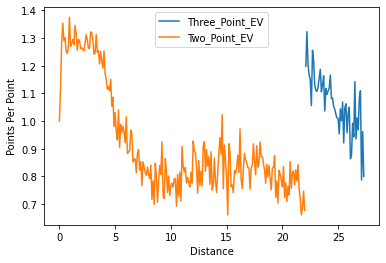

In [12]:
plt.plot(three_pts.SHOT_DIST, three_pts.PTS, label='Three_Point_EV')
plt.plot(two_pts.SHOT_DIST, two_pts.PTS, label='Two_Point_EV')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Points Per Point')
plt.show()

I believe that a fair 3-point line would make it so that the average points per shot for 2-point shots are roughly equal to the points per shot of 3-point shots. When we move the line back further, we get longer and longer twos that slightly decrease the value of 2point shots (fgm % * 2pts). This effect is smaller than the dropoff in shooting percentage of 3-point shots as you go backward. We should still see the 2-point and 3-point points per shot intersect. That will be our magic number

The data sample is large enough that I can compare shooting percentages at various distances. In this function I can set the 3 point threshold and see how the expected value of the 2-pt & 3-pt shots compare

In [19]:
def three_pt_ev(data, dist):
    data.PTS_TYPE=data.SHOT_DIST.apply(lambda x: 3 if x> dist else 2)
    data.PTS=data.FGM*data.PTS_TYPE
    dout=pd.pivot_table(data, index='PTS_TYPE', values='PTS')
    print([dist, dout.PTS.iloc[0], dout.PTS.iloc[1]])
    return[dist, dout.PTS.iloc[0], dout.PTS.iloc[1]]

Here, we loop through the range of 3-point shots that we have sufficent data for. If we still do not find equilibrium before 27.2 feet, we would need to run a logistic regression to extrapolate further.

In [20]:
def get_evs(df):
    shotlist=[]
    for i in np.arange(24.0,27.3,0.01):
        shotlist.append(three_pt_ev(df,i))
    return pd.DataFrame(shotlist, columns=['distance', '2pt_ev', '3pt_ev'])

We can see that around 25.2 feet, the balance shifts to 2pt shots being worth more. Based on this logic, this is a fair place to put the new 3 point line.

In [21]:
ev_by_3pt_dist=get_evs(df)

[24.0, 0.9531582079401513, 1.0068011890820647]
[24.01, 0.9531582079401513, 1.0068011890820647]
[24.020000000000003, 0.9531582079401513, 1.0068011890820647]
[24.030000000000005, 0.9531582079401513, 1.0068011890820647]
[24.040000000000006, 0.9531582079401513, 1.0068011890820647]
[24.050000000000008, 0.9531582079401513, 1.0068011890820647]
[24.06000000000001, 0.9531582079401513, 1.0068011890820647]
[24.07000000000001, 0.9531582079401513, 1.0068011890820647]
[24.080000000000013, 0.9531582079401513, 1.0068011890820647]
[24.090000000000014, 0.9531582079401513, 1.0068011890820647]
[24.100000000000016, 0.9509423373708086, 1.00264725347452]
[24.110000000000017, 0.9509423373708086, 1.00264725347452]
[24.12000000000002, 0.9509423373708086, 1.00264725347452]
[24.13000000000002, 0.9509423373708086, 1.00264725347452]
[24.140000000000022, 0.9509423373708086, 1.00264725347452]
[24.150000000000023, 0.9509423373708086, 1.00264725347452]
[24.160000000000025, 0.9509423373708086, 1.00264725347452]
[24.1700

Here, we plot the cross over point

<AxesSubplot:xlabel='distance'>

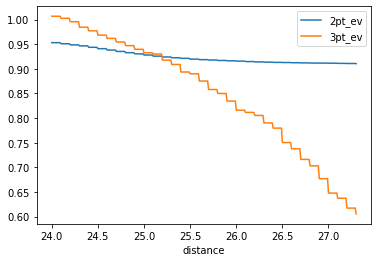

In [22]:
ev_by_3pt_dist.plot.line(x='distance')

My first thought would be, how would this change impact the greatest 3-point shooter ever?

In [23]:
steph_curry=df[df.player_name=='stephen curry']

In [24]:
steph_curry.shape

(968, 21)

In [25]:
steph_threept=get_evs(steph_curry)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[24.0, 1.0875420875420876, 1.179144385026738]
[24.01, 1.0875420875420876, 1.179144385026738]
[24.020000000000003, 1.0875420875420876, 1.179144385026738]
[24.030000000000005, 1.0875420875420876, 1.179144385026738]
[24.040000000000006, 1.0875420875420876, 1.179144385026738]
[24.050000000000008, 1.0875420875420876, 1.179144385026738]
[24.06000000000001, 1.0875420875420876, 1.179144385026738]
[24.07000000000001, 1.0875420875420876, 1.179144385026738]
[24.080000000000013, 1.0875420875420876, 1.179144385026738]
[24.090000000000014, 1.0875420875420876, 1.179144385026738]
[24.100000000000016, 1.09, 1.1657608695652173]
[24.110000000000017, 1.09, 1.1657608695652173]
[24.12000000000002, 1.09, 1.1657608695652173]
[24.13000000000002, 1.09, 1.1657608695652173]
[24.140000000000022, 1.09, 1.1657608695652173]
[24.150000000000023, 1.09, 1.1657608695652173]
[24.160000000000025, 1.09, 1.1657608695652173]
[24.170000000000027, 1.09, 1.1657608695652173]
[24.180000000000028, 1.09, 1.1657608695652173]
[24.1900

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


[24.480000000000075, 1.0588235294117647, 1.1925465838509317]
[24.490000000000077, 1.0588235294117647, 1.1925465838509317]
[24.500000000000078, 1.0500758725341426, 1.203883495145631]
[24.51000000000008, 1.0500758725341426, 1.203883495145631]
[24.52000000000008, 1.0500758725341426, 1.203883495145631]
[24.530000000000083, 1.0500758725341426, 1.203883495145631]
[24.540000000000084, 1.0500758725341426, 1.203883495145631]
[24.550000000000086, 1.0500758725341426, 1.203883495145631]
[24.560000000000088, 1.0500758725341426, 1.203883495145631]
[24.57000000000009, 1.0500758725341426, 1.203883495145631]
[24.58000000000009, 1.0500758725341426, 1.203883495145631]
[24.590000000000092, 1.0500758725341426, 1.203883495145631]
[24.600000000000094, 1.0382352941176471, 1.21875]
[24.610000000000095, 1.0382352941176471, 1.21875]
[24.620000000000097, 1.0382352941176471, 1.21875]
[24.6300000000001, 1.0382352941176471, 1.21875]
[24.6400000000001, 1.0382352941176471, 1.21875]
[24.6500000000001, 1.03823529411764

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


[25.440000000000225, 1.0038022813688212, 1.2402234636871508]
[25.450000000000227, 1.0038022813688212, 1.2402234636871508]
[25.46000000000023, 1.0038022813688212, 1.2402234636871508]
[25.47000000000023, 1.0038022813688212, 1.2402234636871508]
[25.48000000000023, 1.0038022813688212, 1.2402234636871508]
[25.490000000000233, 1.0038022813688212, 1.2402234636871508]
[25.500000000000234, 1.0, 1.2407407407407407]
[25.510000000000236, 1.0, 1.2407407407407407]
[25.520000000000238, 1.0, 1.2407407407407407]
[25.53000000000024, 1.0, 1.2407407407407407]
[25.54000000000024, 1.0, 1.2407407407407407]
[25.550000000000242, 1.0, 1.2407407407407407]
[25.560000000000244, 1.0, 1.2407407407407407]
[25.570000000000245, 1.0, 1.2407407407407407]
[25.580000000000247, 1.0, 1.2407407407407407]
[25.59000000000025, 1.0, 1.2407407407407407]
[25.60000000000025, 1.0012330456226881, 1.2229299363057324]
[25.61000000000025, 1.0012330456226881, 1.2229299363057324]
[25.620000000000253, 1.0012330456226881, 1.2229299363057324

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[25.900000000000297, 0.997624703087886, 1.1904761904761905]
[25.9100000000003, 0.997624703087886, 1.1904761904761905]
[25.9200000000003, 0.997624703087886, 1.1904761904761905]
[25.9300000000003, 0.997624703087886, 1.1904761904761905]
[25.940000000000303, 0.997624703087886, 1.1904761904761905]
[25.950000000000305, 0.997624703087886, 1.1904761904761905]
[25.960000000000306, 0.997624703087886, 1.1904761904761905]
[25.970000000000308, 0.997624703087886, 1.1904761904761905]
[25.98000000000031, 0.997624703087886, 1.1904761904761905]
[25.99000000000031, 0.997624703087886, 1.1904761904761905]
[26.000000000000313, 0.9964580873671782, 1.1900826446280992]
[26.010000000000314, 0.9964580873671782, 1.1900826446280992]
[26.020000000000316, 0.9964580873671782, 1.1900826446280992]
[26.030000000000317, 0.9964580873671782, 1.1900826446280992]
[26.04000000000032, 0.9964580873671782, 1.1900826446280992]
[26.05000000000032, 0.9964580873671782, 1.1900826446280992]
[26.060000000000322, 0.9964580873671782, 1.1

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

[26.340000000000366, 0.9873125720876585, 1.2475247524752475]
[26.350000000000367, 0.9873125720876585, 1.2475247524752475]
[26.36000000000037, 0.9873125720876585, 1.2475247524752475]
[26.37000000000037, 0.9873125720876585, 1.2475247524752475]
[26.380000000000372, 0.9873125720876585, 1.2475247524752475]
[26.390000000000374, 0.9873125720876585, 1.2475247524752475]
[26.400000000000375, 0.9851088201603666, 1.263157894736842]
[26.410000000000377, 0.9851088201603666, 1.263157894736842]
[26.42000000000038, 0.9851088201603666, 1.263157894736842]
[26.43000000000038, 0.9851088201603666, 1.263157894736842]
[26.44000000000038, 0.9851088201603666, 1.263157894736842]
[26.450000000000383, 0.9851088201603666, 1.263157894736842]
[26.460000000000385, 0.9851088201603666, 1.263157894736842]
[26.470000000000386, 0.9851088201603666, 1.263157894736842]
[26.480000000000388, 0.9851088201603666, 1.263157894736842]
[26.49000000000039, 0.9851088201603666, 1.263157894736842]
[26.50000000000039, 0.9863325740318907, 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


[26.76000000000043, 0.983127109111361, 1.2531645569620253]
[26.770000000000433, 0.983127109111361, 1.2531645569620253]
[26.780000000000435, 0.983127109111361, 1.2531645569620253]
[26.790000000000436, 0.983127109111361, 1.2531645569620253]
[26.800000000000438, 0.9831649831649831, 1.2467532467532467]
[26.81000000000044, 0.9831649831649831, 1.2467532467532467]
[26.82000000000044, 0.9831649831649831, 1.2467532467532467]
[26.830000000000442, 0.9831649831649831, 1.2467532467532467]
[26.840000000000444, 0.9831649831649831, 1.2467532467532467]
[26.850000000000446, 0.9831649831649831, 1.2467532467532467]
[26.860000000000447, 0.9831649831649831, 1.2467532467532467]
[26.87000000000045, 0.9831649831649831, 1.2467532467532467]
[26.88000000000045, 0.9831649831649831, 1.2467532467532467]
[26.89000000000045, 0.9831649831649831, 1.2467532467532467]
[26.900000000000453, 0.9832026875699889, 1.24]
[26.910000000000455, 0.9832026875699889, 1.24]
[26.920000000000456, 0.9832026875699889, 1.24]
[26.9300000000

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i


[27.2000000000005, 0.9868131868131869, 1.0862068965517242]
[27.210000000000502, 0.9868131868131869, 1.0862068965517242]
[27.220000000000503, 0.9868131868131869, 1.0862068965517242]
[27.230000000000505, 0.9868131868131869, 1.0862068965517242]
[27.240000000000506, 0.9868131868131869, 1.0862068965517242]
[27.250000000000508, 0.9868131868131869, 1.0862068965517242]
[27.26000000000051, 0.9868131868131869, 1.0862068965517242]
[27.27000000000051, 0.9868131868131869, 1.0862068965517242]
[27.280000000000513, 0.9868131868131869, 1.0862068965517242]
[27.290000000000514, 0.9868131868131869, 1.0862068965517242]
[27.300000000000516, 0.9880043620501636, 1.0]


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

While the sample is fairly small, it appears that this change would not impact steph at all. Actually, at 25.2' he improves on his points per shot, which is astronomical. This suggests to me that he could dominate even in a league where the 3-point line was penalized further. I also think this is a legitimate case for moving the line back. If great 3-point shooters are still able to help their team, keeps them relevant without making them completely indespensable to a team.

<AxesSubplot:xlabel='distance'>

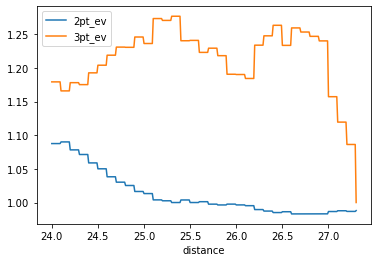

In [26]:
steph_threept.plot.line(x='distance')

With this in mind. I wanted to see how far out they would have to put a 4 point line. I will be using the assumption that the 3-point line has been changed to 25.2 for this hypothetical. We will also use the same logic. How far out does a 4 point line have to be to make the expected value of the shots equal to that of 2 & 3 point shots?

With this it is important to note that we need to project the number of shots from ranges as well. When we were using actual data, this was not necessary because it was implicitly included. With this new method, we need to incorporate this.

In [27]:
from sklearn.linear_model import LogisticRegression

I use a logistic regression to extrapolate out make percentages beyond 27.3 feet.

I split the model into two parts, one for close to rim shots (<= 4') and one for all other shots. Splitting the model produced better results than a single one

In [30]:
less4 = df[df.SHOT_DIST <= 4]
log_reg_less4 = LogisticRegression()
log_reg_less4.fit(less4.SHOT_DIST.values.reshape(-1, 1),less4.FGM.values.reshape(-1, 1))
print(log_reg_less4.score(less4.SHOT_DIST.values.reshape(-1, 1),less4.FGM.values.reshape(-1, 1)))

0.635798539599326


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [31]:
greater4 = df[df.SHOT_DIST > 4]
log_reg_greater4 = LogisticRegression()
log_reg_greater4.fit(greater4.SHOT_DIST.values.reshape(-1, 1),greater4.FGM.values.reshape(-1, 1))
print(log_reg_greater4.score(greater4.SHOT_DIST.values.reshape(-1, 1),greater4.FGM.values.reshape(-1, 1)))

0.5962471883508939


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Quick test for accuracy

In [32]:
log_reg_greater4.predict_proba(np.array(24).reshape(-1,1))

array([[0.64615903, 0.35384097]])

Very small error here, this appears stable enough that we can extrapolate this further from the rim.

In [34]:
from sklearn.metrics import mean_squared_error
makepcts=make_pct_dist[(make_pct_dist.SHOT_DIST >=23.75) & (make_pct_dist.SHOT_DIST <=27.3)]
ypred=log_reg_greater4.predict_proba(makepcts.SHOT_DIST.values.reshape(-1,1))
ypred[:,1]
mean_squared_error(makepcts.FGM,ypred[:,1])

0.0007421265041851429

In [37]:
def Three_point_proj(fit_model, fit_model2, dist):
    for i in arange(23.75,40.0,0.01):
        data.PTS=data.FGM* data.PTS_TYPE
        dout=pd.pivot_table(data, index='PTS_TYPE', values='PTS')
        print([dist, dout.PTS.iloc[0], dout.PTS.iloc[1]])
        return[dist,dout.PTS.iloc[0],dout.PTS.iloc[1]]

In [38]:
def four_point_proj(fit_model, fit_model2,dist):
    data.PTS_TYPE=data.SHOT_DIST.apply(lambda x: 3 if x>dist else 2)
    data.PTS=data.FGM* data.PTS_TYPE
    dout=pd.pivot_table(data, index='PTS_TYPE', values='PTS')
    print([dist,dout.PTS.iloc[0],dout.PTS.ILOC[1]])
    return [dist,dout.PTS.iloc[0], dout.PTS.iloc[1]]

In [39]:
Three_point_proj

<function __main__.Three_point_proj(fit_model, fit_model2, dist)>